Import Neccessary Libraries

In [27]:
import tensorflow as tf
import matplotlib.pyplot
from tensorflow.python import pywrap_tensorflow
from tensorflow.keras import layers

Setting Up Dataset Paths

In [2]:
import os
print("current Directory",os.getcwd())
curr_dir=os.getcwd()
train_path=os.path.join(curr_dir,"Potato-Dataset","Train")
print(train_path)
test_path=os.path.join(curr_dir,"Potato-Dataset","Test")
print(test_path)
valid_path=os.path.join(curr_dir,"Potato-Dataset","Valid")
print(valid_path)


current Directory c:\Users\Admin\Documents\Potata-leaf-detection-prediction
c:\Users\Admin\Documents\Potata-leaf-detection-prediction\Potato-Dataset\Train
c:\Users\Admin\Documents\Potata-leaf-detection-prediction\Potato-Dataset\Test
c:\Users\Admin\Documents\Potata-leaf-detection-prediction\Potato-Dataset\Valid


Data Augmentation for Training Set

In [31]:

augmentation_train_set = tf.keras.Sequential([
    layers.RandomRotation(0.4),        
    layers.RandomZoom(0.2),           
    layers.RandomContrast(0.2),       
    layers.RandomFlip("horizontal"),   
    layers.RandomWidth(0.1),           
    layers.RandomHeight(0.1),         
    layers.RandomShear(0.2), 
    layers.Resizing(128, 128)          
])

Loading and Preprocessing Training Dataset

In [32]:
training_set=tf.keras.utils.image_dataset_from_directory(
  train_path,
  labels="inferred",
  label_mode="categorical",
  color_mode="rgb",  
  image_size=(128,128),
  shuffle=True,
  interpolation="bilinear",
)

Found 900 files belonging to 3 classes.


In [33]:
training_set.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

Optimizing Data Loading and Augmentation Pipeline with AUTOTUNE

In [34]:
AUTOTUNE = tf.data.AUTOTUNE  
training_set = training_set.map(
    lambda x, y: (augmentation_train_set(x, training=True), y),  
    num_parallel_calls=AUTOTUNE ).prefetch(buffer_size=AUTOTUNE) 

In [35]:
for images, labels in training_set.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)


Image batch shape: (32, 128, 128, 3)
Label batch shape: (32, 3)


Loading and Preprocessing validation Dataset

In [36]:
validation_set=tf.keras.utils.image_dataset_from_directory(
  valid_path,
  labels="inferred",
  label_mode="categorical",
  color_mode="rgb",  
  image_size=(128,128),
  shuffle=True,
  interpolation="bilinear",
)

Found 300 files belonging to 3 classes.


Building the Convolutional Neural Network (CNN)

In [37]:
cnn=tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=(128,128,3)))
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [39]:
cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [40]:
cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [41]:
cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [42]:
cnn.add(tf.keras.layers.Dropout(0.3)) #0.25
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=1500,activation='relu')) #1500
cnn.add(tf.keras.layers.Dropout(0.4))
cnn.add(tf.keras.layers.Dense(units=3,activation='softmax'))


Compiling the CNN Model

In [43]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [44]:
cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1500)           │     3,073,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         4,503 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,790,227 (29.72 MB)

 Trainable params: 7,790,227 (29.72 MB)

 Non-trainable params: 0 (0.00 B)

Training the CNN Model

In [45]:
training_history = cnn.fit(x=training_set, validation_data=validation_set,epochs=10)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3274 - loss: 1.5724 - val_accuracy: 0.3900 - val_loss: 1.0307
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6293 - loss: 0.8087 - val_accuracy: 0.6700 - val_loss: 0.6256
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7058 - loss: 0.6456 - val_accuracy: 0.6333 - val_loss: 0.8735
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7497 - loss: 0.5725 - val_accuracy: 0.7567 - val_loss: 0.5220
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7405 - loss: 0.5203 - val_accuracy: 0.8600 - val_loss: 0.3515
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8341 - loss: 0.3850 - val_accuracy: 0.8900 - val_loss: 0.2902
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8972 - loss: 0.2729 - val_accuracy: 0.8233 - val_loss: 0.4258
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8803 - loss: 0.3638 - val_accuracy: 0.9000 - val_loss:

Evaluation the CNN Model

In [46]:
train_loss,train_acc = cnn.evaluate(training_set)
print('training_accuracy',train_acc)

29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.9318 - loss: 0.1813
training_accuracy 0.9366666674613953


In [47]:
valid_loss,valid_acc = cnn.evaluate(validation_set)
print('validation_accuracy',valid_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - accuracy: 0.9109 - loss: 0.2326
validation_accuracy 0.9066666960716248


Save the CNN Model

In [48]:
cnn.save("trained_potato_plant_disease_model-1.keras")

In [50]:
training_history.history

{'accuracy': [0.38555556535720825,
  0.6788889169692993,
  0.742222249507904,
  0.7688888907432556,
  0.7799999713897705,
  0.8588888645172119,
  0.8888888955116272,
  0.8911111354827881,
  0.8833333253860474,
  0.9066666960716248],
 'loss': [1.2639042139053345,
  0.7152734994888306,
  0.5827006101608276,
  0.5374341011047363,
  0.4564255177974701,
  0.3408293128013611,
  0.30132022500038147,
  0.3096490502357483,
  0.300249308347702,
  0.2469872385263443],
 'val_accuracy': [0.38999998569488525,
  0.6700000166893005,
  0.6333333253860474,
  0.7566666603088379,
  0.8600000143051147,
  0.8899999856948853,
  0.8233333230018616,
  0.8999999761581421,
  0.8700000047683716,
  0.9066666960716248],
 'val_loss': [1.0306581258773804,
  0.6256117820739746,
  0.8734702467918396,
  0.5220056772232056,
  0.3514595329761505,
  0.29017746448516846,
  0.4258204400539398,
  0.2529764175415039,
  0.35709723830223083,
  0.2410893738269806]}

Plotting Training and Validation Curves

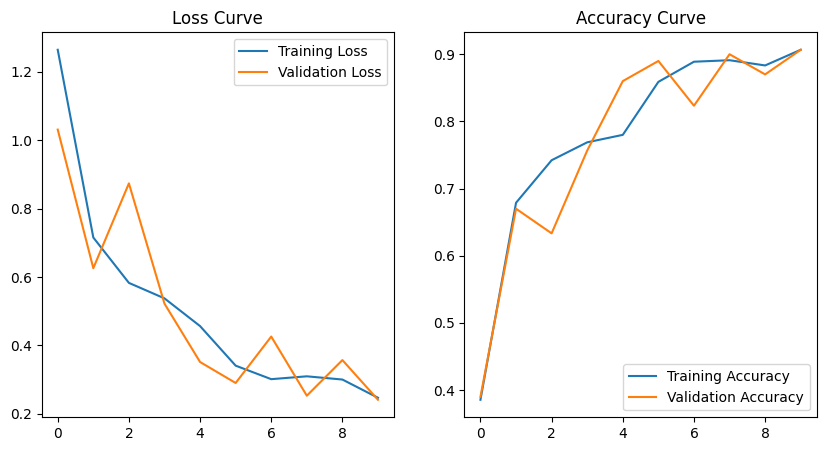

In [51]:
import matplotlib.pyplot as plt

# Extract history
train_loss = training_history.history['loss']
val_loss = training_history.history['val_loss']
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss Curve")

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


In [52]:
test_set = tf.keras.utils.image_dataset_from_directory(
    test_path, labels="inferred", label_mode="categorical", color_mode="rgb",
    image_size=(128, 128), shuffle=False, interpolation="bilinear"
)

Found 300 files belonging to 3 classes.


In [53]:
test_loss, test_accuracy = cnn.evaluate(test_set)

# Print the test accuracy
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.9374 - loss: 0.1491
✅ Test Accuracy: 93.33%
